In [ ]:
!pip install yahoofinancials

In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, v_measure_score, mean_squared_error

In [7]:
def get_bitcoin_candlestick(start_date, end_date):
    """  get bitcoin daily info from yahooFinancials and remove non values"""

    yahoo_financials = YahooFinancials('BTC-USD')
    btc_daily_dataset = yahoo_financials.get_historical_price_data(
                            start_date, end_date, "daily")

    btc_daily_df = pd.DataFrame(btc_daily_dataset['BTC-USD']['prices'])

    # btc_daily_df = btc_daily_df.drop('date', axis=1)
    btc_daily_df = btc_daily_df.set_index('formatted_date')
    btc_daily_df = btc_daily_df.dropna()

    # Normalize date column
    scaler = preprocessing.MinMaxScaler()
    scaler.fit(btc_daily_df[['date']])
    btc_daily_df['date'] = scaler.transform(btc_daily_df[['date']])

    return btc_daily_df


btc_df = get_bitcoin_candlestick(start_date="2022-01-01", end_date="2022-03-30")
btc_df.head()

,date,high,low,open,close,volume,adjclose
formatted_date,,,,,,,
2022-01-01,0.000000,47827.312500,46288.484375,46311.746094,47686.812500,24582667004,47686.812500
2022-01-02,0.011364,47881.406250,46856.937500,47680.925781,47345.218750,27951569547,47345.218750
2022-01-03,0.022727,47510.726562,45835.964844,47343.542969,46458.117188,33071628362,46458.117188
2022-01-04,0.034091,47406.546875,45752.464844,46458.851562,45897.574219,42494677905,45897.574219
2022-01-05,0.045455,46929.046875,42798.222656,45899.359375,43569.003906,36851084859,43569.003906


In [8]:
def plot_bitcoin_daily_candlestick(btc_df, length):

    fig = go.Figure(data=[go.Candlestick(
            x=btc_df.index,
            open=btc_df.iloc[-length:]['open'],
            high=btc_df.iloc[-length:]['high'],
            low=btc_df.iloc[-length:]['low'],
            close=btc_df.iloc[-length:]['close'])])

    fig.update_layout(
        width=900,
        height=450,
        title=dict(text='<b>Bitcoin/USD Chart</b>', font=dict(size=30)),
        yaxis_title=dict(text='Price (USD)', font=dict(size=15)),
        margin=dict(l=10, r=20, t=80, b=20)
    )

    fig.show()


plot_bitcoin_daily_candlestick(btc_df, 100)

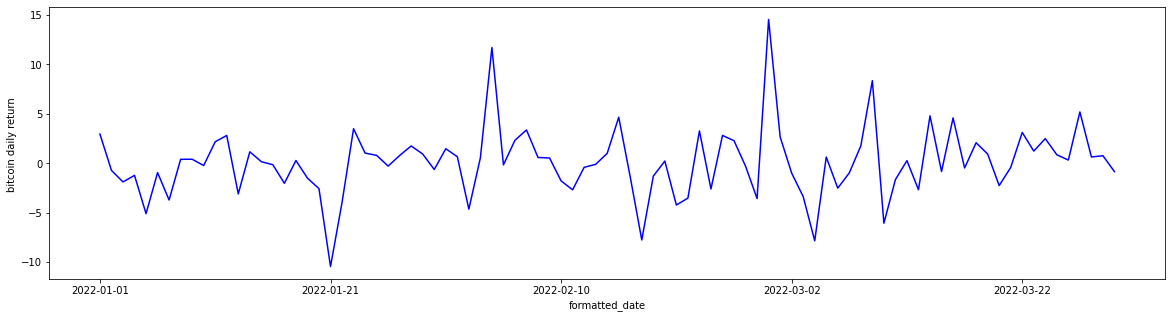

In [9]:
def calculate_btc_daily_return(btc_df):
    
    btc_df['daily_return'] = 100 * (
        (btc_df['close'] - btc_df['open']) / btc_df['open'])

    return btc_df


# Plot the daily return
btc_df = calculate_btc_daily_return(btc_df)
btc_df.daily_return.plot(figsize=(20, 5), color='b')
plt.ylabel("bitcoin daily return ")
plt.show()

## **Kmean clustering**

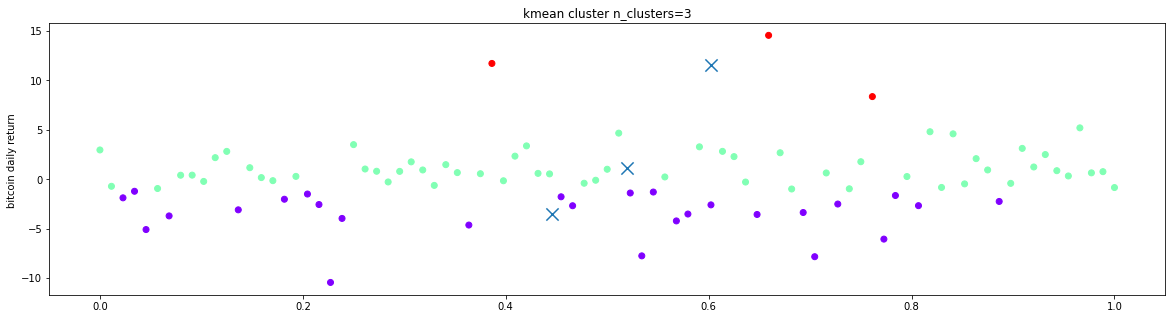

In [47]:
# %%pycodestyle
def cluster_btc_daily_returns_kmean(num_clusters, cluster_data):

    """ cluster daily return and plot clusters """

    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(cluster_data)
    predicts = kmeans.predict(cluster_data)

    btc_df['cluster'] = pd.Series(predicts, index=btc_df.index)
    centroids = kmeans.cluster_centers_

    plt.figure(figsize=(20, 5))
    plt.scatter(cluster_data['date'], cluster_data['daily_return'],
                c=kmeans.labels_, cmap="rainbow")
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker="x", s=150, linewidths=5, zorder=10)
    plt.ylabel("bitcoin daily return ")
    plt.title("kmean cluster n_clusters=%d"%num_clusters)
    plt.show()


btc_cluster_data = btc_df[['date', 'daily_return']]
cluster_btc_daily_returns_kmean(num_clusters=3, cluster_data=btc_cluster_data)

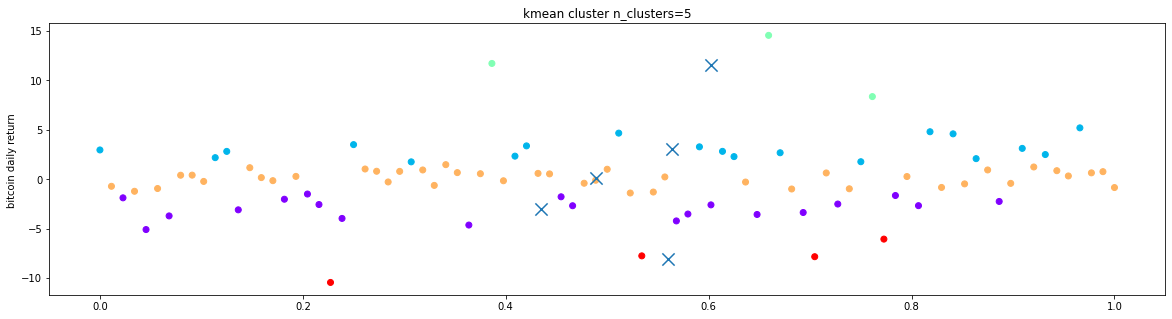

In [63]:
cluster_btc_daily_returns_kmean(num_clusters=5,
                                cluster_data=btc_cluster_data)

In [65]:
btc_df.head()
btc_df.to_pickle("./bitcoin_dataset.pkl") 

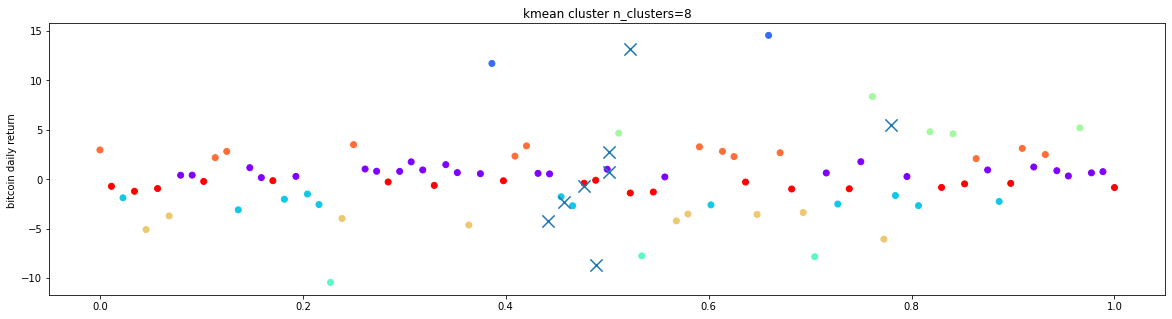

In [49]:
cluster_btc_daily_returns_kmean(num_clusters=8,
                                cluster_data=btc_cluster_data)

## **DBSCAN clustering**

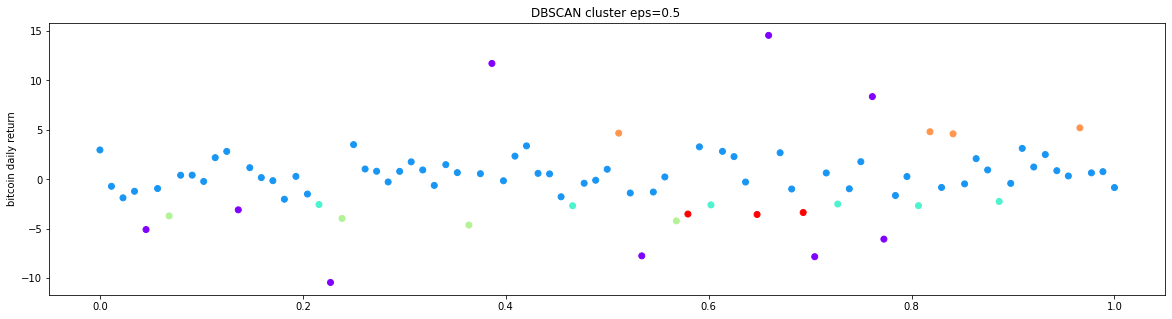

Estimated no. of clusters: 5
Estimated no. of noise points: 9


In [44]:
# %%pycodestyle
def cluster_btc_daily_return_DBSCAN(epsilon, min_num_samples, cluster_data):

    dbscan = DBSCAN(eps=epsilon, min_samples=min_num_samples)
    dbscan.fit(cluster_data)

    plt.figure(figsize=(20, 5))
    plt.scatter(cluster_data['date'], cluster_data['daily_return'],
                c=dbscan.labels_, cmap="rainbow")
    plt.ylabel("bitcoin daily return")
    plt.title("DBSCAN cluster eps=%0.1f " %epsilon )
    plt.show()

    # Number of Clusters
    labels = dbscan.labels_
    N_clus = len(set(labels)) - (1 if -1 in labels else 0)
    print('Estimated no. of clusters: %d' % N_clus)

    # Identify Noise
    n_noise = list(dbscan.labels_).count(-1)
    print('Estimated no. of noise points: %d' % n_noise)


cluster_btc_daily_return_DBSCAN(epsilon=0.5, min_num_samples=3,
                                cluster_data=btc_cluster_data)

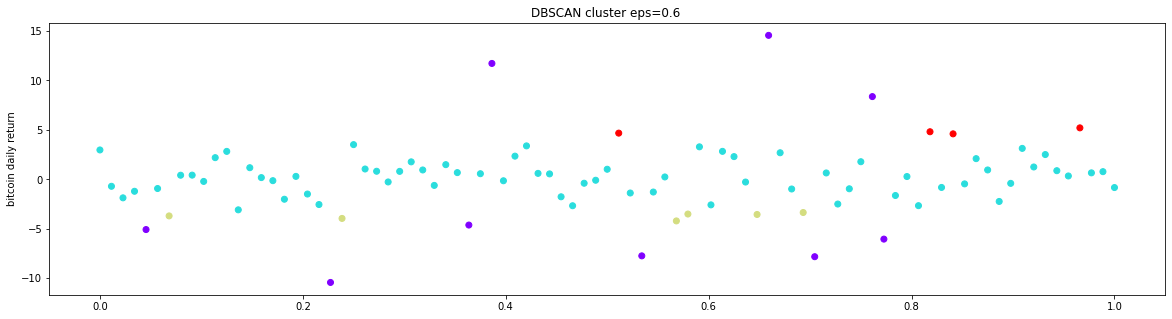

Estimated no. of clusters: 3
Estimated no. of noise points: 9


In [62]:
cluster_btc_daily_return_DBSCAN(epsilon=0.6, min_num_samples=4,
                                cluster_data=btc_cluster_data)